# Computer Vision Validation



In [1]:
import torch
import pickle
import wallaroo
import os
import numpy as np
import json
import requests
import time
import pandas as pd
from CVDemoUtils import CVDemo

from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from CVDemoUtils import CVDemo
cvDemo = CVDemo()
cvDemo.COCO_CLASSES_PATH = "models/coco_classes.pickle"


### Securely connect this Notebook to the Wallaroo Cluster

In [2]:
wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Set the current workspace to "computer-vision"

In [3]:
# used for unique connection names

# import string
# import random

# suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

suffix='jch'

workspace_name = f'cv-retail{suffix}'

pipeline_name = 'cv-retail-pipeline'

In [4]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

pipeline = get_pipeline(pipeline_name)

### Upload model to wallaroo

In [5]:
# assuming they were uploaded - grab them

mobilenet_model_name = 'mobilenet'
# mobilenet_model_path = "./models/mobilenet.pt.onnx"

resnet_model_name = 'resnet'


def get_model(mname):
    modellist = wl.get_current_workspace().models()
    model = [m.versions()[0] for m in modellist if m.name() == mname]
    if len(model) <= 0:
        raise KeyError(f"model {mname} not found in this workspace")
    return model[0]

mobilenet_model = get_model(mobilenet_model_name)

resnet_model = get_model(resnet_model_name)

step_name = "cv-post-process-drift-detection"

module_post_process = get_model(step_name)


### Upload the post processing module code to Wallaroo

Next we will add our post processing anomoly detection file that will take the average of the confidences.  We will use this value to detect drift.</b>

In [6]:
# import pyarrow as pa

# field_boxes = pa.field('boxes', pa.list_(pa.list_(pa.float64(), 4)))
# field_classes = pa.field('classes', pa.list_(pa.int32()))
# field_confidences =  pa.field('confidences', pa.list_(pa.float64()))

# # field_boxes - will have a flattened array of the 4 coordinates representing the boxes.  128 entries
# # field_classes - will have 32 entries
# # field_confidences - will have 32 entries
# input_schema = pa.schema([field_boxes, field_classes, field_confidences])

# output_schema = pa.schema([
#     field_boxes,
#     field_classes,
#     field_confidences,
#     pa.field('avg_conf', pa.list_(pa.float64()))
# ])

In [7]:
# module_post_process = wl.upload_model("cv-post-process-drift-detection", 
#                                       "./models/post-process-drift-detection-arrow.py",
#                                       framework=Framework.PYTHON ).configure('python', 
#                                                                              input_schema=input_schema, 
#                                                                              output_schema=output_schema
#                                     )


### Reserve resources needed for this pipeline from the Wallaroo Cluster

In [33]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(1).replica_autoscale_min_max(minimum=2, maximum=5).cpus(1).memory("1Gi").build()

### Create the pipeline and add the post processing module as a step in the pipeline

In [9]:
#pipeline_name = 'cam-atl-1-anm'
#pipeline = wl.build_pipeline(pipeline_name) \
#            .add_model_step(mobilenet_model) \
#            .deploy(deployment_config = deployment_config)

In [11]:
# in case this was run before
pipeline.undeploy()
pipeline.clear()
pipeline.add_model_step(mobilenet_model)
pipeline.add_model_step(module_post_process)

name,cv-retail-pipeline
created,2023-07-28 19:26:41.215539+00:00
last_updated,2023-07-28 19:33:18.497235+00:00
deployed,False
tags,
versions,"8a067ab5-7423-4554-82ac-d75594fe4ca4, 71f5ffae-e74c-459b-b30a-b6a3ae260695, c9cfcb2d-d789-4cdd-8e62-b5108192179f, 5e1d35ef-fb98-4ffe-8344-93609046f025, 3bd9a6ce-4ccb-4a93-9ccb-ae559e91048c"
steps,mobilenet


In [41]:
pipeline.deploy(deployment_config = deployment_config)

name,cv-retail-pipeline
created,2023-07-28 19:26:41.215539+00:00
last_updated,2023-07-28 21:05:29.220812+00:00
deployed,True
tags,
versions,"e82d7f86-2646-4946-900e-e371d48c4c75, de2a9ad5-7a98-4a43-80d5-6e55a0c813f6, bfe5c1eb-e129-4093-99a2-8e588d4abcec, dc13ac9b-90c3-49d1-86f0-83c3d3186173, 8a067ab5-7423-4554-82ac-d75594fe4ca4, 71f5ffae-e74c-459b-b30a-b6a3ae260695, c9cfcb2d-d789-4cdd-8e62-b5108192179f, 5e1d35ef-fb98-4ffe-8344-93609046f025, 3bd9a6ce-4ccb-4a93-9ccb-ae559e91048c"
steps,mobilenet


In [42]:
pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': None,
   'name': 'engine-675c599c47-5w9gd',
   'status': 'Pending',
   'reason': None,
   'details': ['containers with unready status: [engine]',
    'containers with unready status: [engine]'],
   'pipeline_statuses': None,
   'model_statuses': None},
  {'ip': '10.244.3.112',
   'name': 'engine-675c599c47-tc49m',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'cv-retail-pipeline',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'cv-post-process-drift-detection',
      'version': '96f3d490-37fc-4c6a-a731-04d19b977443',
      'sha': 'f60c8ca55c6350d23a4e76d24cc3e5922616090686e88c875fadd6e79c403be5',
      'status': 'Running'},
     {'name': 'mobilenet',
      'version': '1f3e1ff3-92f4-4b38-88a2-e3425c93b0a9',
      'sha': '9044c970ee061cc47e0c77e20b05e884be37f2a20aa9c0c3ce1993dbd486a830',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.

In [17]:
pipeline.steps()

[{'ModelInference': {'models': [{'name': 'mobilenet', 'version': '1f3e1ff3-92f4-4b38-88a2-e3425c93b0a9', 'sha': '9044c970ee061cc47e0c77e20b05e884be37f2a20aa9c0c3ce1993dbd486a830'}]}},
 {'ModelInference': {'models': [{'name': 'cv-post-process-drift-detection', 'version': '96f3d490-37fc-4c6a-a731-04d19b977443', 'sha': 'f60c8ca55c6350d23a4e76d24cc3e5922616090686e88c875fadd6e79c403be5'}]}}]

## Test the pipeline by running inference on a sample image

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

In [43]:
width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe('data/images/input/example/dairy_bottles.png', 
                                                              width, 
                                                              height
                                                              )

In [44]:
dfImage


,tensor
0,[[[[0.9372549 0.9529412 0.9490196 0.9450980...


# Run inference using the SDK 

Now lets have the model detect the objects on the image by running inference and extracting the results 

In [45]:
# Generate a series of inferences to build assays from this input

# build a dataframe of the images

batch_inferences = []

for i in range(100):
    batch_inferences.append(dfImage)

In [46]:
import datetime

startBaseline = datetime.datetime.now()
startTime = time.time()
# infResults = pipeline.infer(dfImage)
parallel_results = await pipeline.parallel_infer(tensor_list=batch_inferences, num_parallel=8, retries=2)
endTime = time.time()
endBaseline = datetime.datetime.now()

In [47]:
parallel_results[0]

,time,in.tensor,out.avg_conf,out.boxes,out.classes,out.confidences,check_failures
0,2023-07-28 21:06:10.224,"[0.9372549057, 0.9529411793, 0.9490196109, 0.9...",[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0


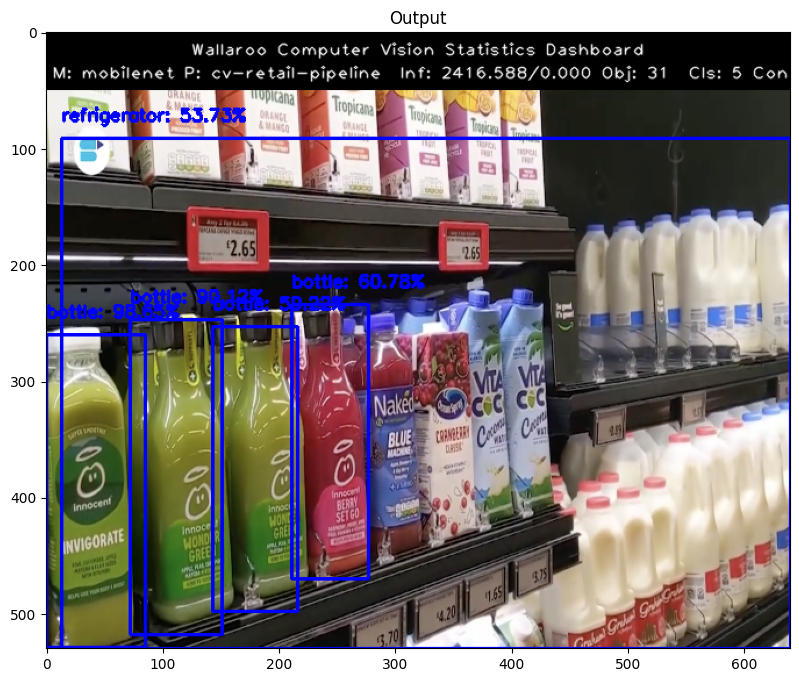

In [28]:
elapsed = 1.0
#elapsed = infResults['elapsed']
results = {
    'model_name' : mobilenet_model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : parallel_results[0],
    'confidence-target' : 0.50,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(results)

In [29]:
# pipeline.logs()
pipeline.logs()

,time,in.tensor,out.avg_conf,out.boxes,out.classes,out.confidences,check_failures
0,2023-07-28 20:49:24.297,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
1,2023-07-28 20:49:23.024,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
2,2023-07-28 20:49:15.786,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
3,2023-07-28 20:49:13.578,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
4,2023-07-28 20:49:10.293,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
...,...,...,...,...,...,...,...
61,2023-07-28 20:44:30.224,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
62,2023-07-28 20:44:29.894,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
63,2023-07-28 20:44:21.409,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
64,2023-07-28 20:44:14.717,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0


## Build Assay



In [48]:
assay_name = "cv assay 01"
assay_builder = wl.build_assay(assay_name, 
                               pipeline, 
                               step_name, 
                               startBaseline, 
                               endBaseline).add_iopath("output avg_conf 0")

In [49]:
baseline_run = assay_builder.build().interactive_baseline_run()

In [50]:
assay_builder.baseline_dataframe()

,time,metadata,input_tensor_0,output_avg_conf_0,output_boxes_0,output_boxes_1,output_boxes_2,output_boxes_3,output_boxes_4,output_boxes_5,...,output_confidences_21,output_confidences_22,output_confidences_23,output_confidences_24,output_confidences_25,output_confidences_26,output_confidences_27,output_confidences_28,output_confidences_29,output_confidences_30
0,1690578377112,"{'last_model': '{""model_name"":""cv-post-process...",None,0.289505,"[0.0, 210.29010009765625, 85.26463317871094, 4...","[72.03781127929688, 197.32269287109375, 151.44...","[211.2801513671875, 184.72837829589844, 277.21...","[143.23904418945312, 203.83004760742188, 216.8...","[13.095015525817873, 41.91339111328125, 640.0,...","[106.51464080810548, 206.14498901367188, 159.5...",...,0.122186,0.121301,0.119561,0.115278,0.096163,0.086548,0.078407,0.072341,0.062821,0.052788
1,1690578377767,"{'last_model': '{""model_name"":""cv-post-process...",None,0.289505,"[0.0, 210.29010009765625, 85.26463317871094, 4...","[72.03781127929688, 197.32269287109375, 151.44...","[211.2801513671875, 184.72837829589844, 277.21...","[143.23904418945312, 203.83004760742188, 216.8...","[13.095015525817873, 41.91339111328125, 640.0,...","[106.51464080810548, 206.14498901367188, 159.5...",...,0.122186,0.121301,0.119561,0.115278,0.096163,0.086548,0.078407,0.072341,0.062821,0.052788
2,1690578378093,"{'last_model': '{""model_name"":""cv-post-process...",None,0.289505,"[0.0, 210.29010009765625, 85.26463317871094, 4...","[72.03781127929688, 197.32269287109375, 151.44...","[211.2801513671875, 184.72837829589844, 277.21...","[143.23904418945312, 203.83004760742188, 216.8...","[13.095015525817873, 41.91339111328125, 640.0,...","[106.51464080810548, 206.14498901367188, 159.5...",...,0.122186,0.121301,0.119561,0.115278,0.096163,0.086548,0.078407,0.072341,0.062821,0.052788
3,1690578387109,"{'last_model': '{""model_name"":""cv-post-process...",None,0.289505,"[0.0, 210.29010009765625, 85.26463317871094, 4...","[72.03781127929688, 197.32269287109375, 151.44...","[211.2801513671875, 184.72837829589844, 277.21...","[143.23904418945312, 203.83004760742188, 216.8...","[13.095015525817873, 41.91339111328125, 640.0,...","[106.51464080810548, 206.14498901367188, 159.5...",...,0.122186,0.121301,0.119561,0.115278,0.096163,0.086548,0.078407,0.072341,0.062821,0.052788
4,1690578399703,"{'last_model': '{""model_name"":""cv-post-process...",None,0.289505,"[0.0, 210.29010009765625, 85.26463317871094, 4...","[72.03781127929688, 197.32269287109375, 151.44...","[211.2801513671875, 184.72837829589844, 277.21...","[143.23904418945312, 203.83004760742188, 216.8...","[13.095015525817873, 41.91339111328125, 640.0,...","[106.51464080810548, 206.14498901367188, 159.5...",...,0.122186,0.121301,0.119561,0.115278,0.096163,0.086548,0.078407,0.072341,0.062821,0.052788
5,1690578401928,"{'last_model': '{""model_name"":""cv-post-process...",None,0.289505,"[0.0, 210.29010009765625, 85.26463317871094, 4...","[72.03781127929688, 197.32269287109375, 151.44...","[211.2801513671875, 184.72837829589844, 277.21...","[143.23904418945312, 203.83004760742188, 216.8...","[13.095015525817873, 41.91339111328125, 640.0,...","[106.51464080810548, 206.14498901367188, 159.5...",...,0.122186,0.121301,0.119561,0.115278,0.096163,0.086548,0.078407,0.072341,0.062821,0.052788
6,1690578409574,"{'last_model': '{""model_name"":""cv-post-process...",None,0.289505,"[0.0, 210.29010009765625, 85.26463317871094, 4...","[72.03781127929688, 197.32269287109375, 151.44...","[211.2801513671875, 184.72837829589844, 277.21...","[143.23904418945312, 203.83004760742188, 216.8...","[13.095015525817873, 41.91339111328125, 640.0,...","[106.51464080810548, 206.14498901367188, 159.5...",...,0.122186,0.121301,0.119561,0.115278,0.096163,0.086548,0.078407,0.072341,0.062821,0.052788
7,1690578415662,"{'last_model': '{""model_name"":""cv-post-process...",None,0.289505,"[0.0, 210.29010009765625, 85.26463317871094, 4...","[72.03781127929688, 197.32269287109375, 151.44...","[211.280151

In [51]:
baseline_run.baseline_stats()

,Baseline
count,54
min,0.289505
max,0.289505
mean,0.289505
median,0.289505
std,0.0
start,2023-07-28T21:05:53.647841Z
end,2023-07-28T21:12:30.004970Z


In [52]:
pipeline.undeploy()

name,cv-retail-pipeline
created,2023-07-28 19:26:41.215539+00:00
last_updated,2023-07-28 21:05:29.220812+00:00
deployed,False
tags,
versions,"e82d7f86-2646-4946-900e-e371d48c4c75, de2a9ad5-7a98-4a43-80d5-6e55a0c813f6, bfe5c1eb-e129-4093-99a2-8e588d4abcec, dc13ac9b-90c3-49d1-86f0-83c3d3186173, 8a067ab5-7423-4554-82ac-d75594fe4ca4, 71f5ffae-e74c-459b-b30a-b6a3ae260695, c9cfcb2d-d789-4cdd-8e62-b5108192179f, 5e1d35ef-fb98-4ffe-8344-93609046f025, 3bd9a6ce-4ccb-4a93-9ccb-ae559e91048c"
steps,mobilenet


AttributeError: 'float' object has no attribute 'tzinfo'

In [39]:
pipeline.undeploy()

name,cv-retail-pipeline
created,2023-07-28 19:26:41.215539+00:00
last_updated,2023-07-28 20:58:43.930623+00:00
deployed,False
tags,
versions,"de2a9ad5-7a98-4a43-80d5-6e55a0c813f6, bfe5c1eb-e129-4093-99a2-8e588d4abcec, dc13ac9b-90c3-49d1-86f0-83c3d3186173, 8a067ab5-7423-4554-82ac-d75594fe4ca4, 71f5ffae-e74c-459b-b30a-b6a3ae260695, c9cfcb2d-d789-4cdd-8e62-b5108192179f, 5e1d35ef-fb98-4ffe-8344-93609046f025, 3bd9a6ce-4ccb-4a93-9ccb-ae559e91048c"
steps,mobilenet
